In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from time import time
from os import listdir, path

from numpy.random import choice, shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.stats import zscore
from dtaidistance import dtw, dtw_c, dtw_ndim
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split


from IPython.display import clear_output

In [2]:
%load_ext autoreload
%autoreload 1

import preprocessing
import utils
from models import Encoder, DecoderLinear, DecoderLSTM, Sequence2Sequence

%aimport preprocessing
%aimport models
%aimport utils

In [3]:
device = torch.device("cuda")
BASE_PATH = "../data/Univariate_arff"
TRAIN = "_TRAIN"
TEST = "_TEST"

BIG_CONST = 100000
datasets = [name for name in listdir(BASE_PATH) if path.isdir(path.join(BASE_PATH, name))]

In [4]:
with open("../data/length_Univariate_arff.json") as f:
    lengths = json.load(f)

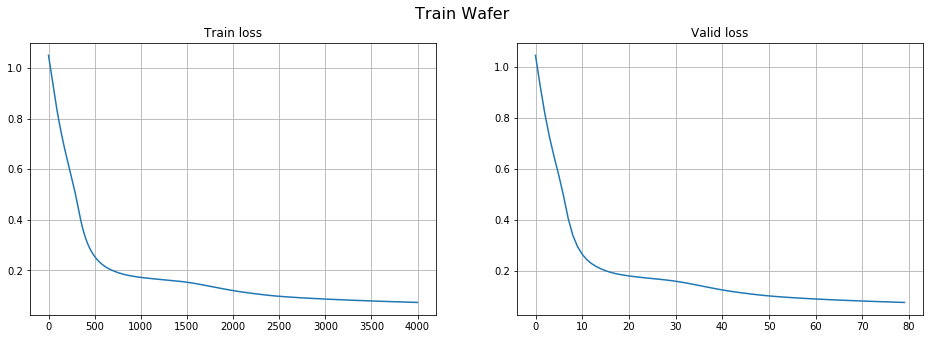

Wafer
hidden_ts: 217.898
raw_ts: 288.795
Raw ts score: 0.926 +- 0.023
Hidden ts score: 0.926 +- 0.017



In [5]:
w = 3
k = 3
hidden_dim = 3
sample_size = 150

valid_size = 0.75
test_size = 0.05

results = {name: {} for name in datasets}
try:
    for idx, problem in enumerate([name for name in datasets if lengths[name] < 200]):    
        length = lengths[problem]
        data_path = path.join(BASE_PATH, problem, problem)    
        
        enc = Encoder(length, 2*k, hidden_dim).cuda()
        dec = DecoderLinear(length, 2*k, hidden_dim).cuda()
        model = Sequence2Sequence(enc, dec) 
        
        X, y = preprocessing.get_dataset(data_path, length=length)
        X = X[:sample_size]
        y = y[:sample_size]
        
        train_set, test_set, valid_set = preprocessing.prepare_data(X, y, k, w, device)
        train_it = iter(train_set)
        
        opt = torch.optim.Adam(model.parameters())
        loss_fn = nn.MSELoss()
        utils.train(model, train_set, opt, loss_fn, valid_set, 4000, problem)

        valid_it = iter(valid_set)
        batch, timeseries, labels = next(valid_it)
        timeseries = timeseries.numpy()
        idxs = np.arange(len(timeseries)).reshape(-1, 1)

        scores_hidden = []
        scores_ts = []
        t = time()
        hiddens, state = enc(batch.permute(1, 0, 2))
        hiddens = hiddens.permute(1, 0, 2).cpu().detach().numpy()

        print(problem)
        scores_ts, scores_hidden = utils.classify(timeseries, hiddens, labels)
        results[problem]["ts"] = scores_ts
        results[problem]["hidden"] = scores_hidden
        results[problem]["shape"] = X.shape
        results[problem]["balance"] = np.unique(y, return_counts=True)
        print()

        with open("results_ae_l.json", "w") as f:
            json.dump(results, f)

except Exception as exc:
    with open("results_ae_l.json", "w") as f:
        json.dump(results, f)

    raise exc

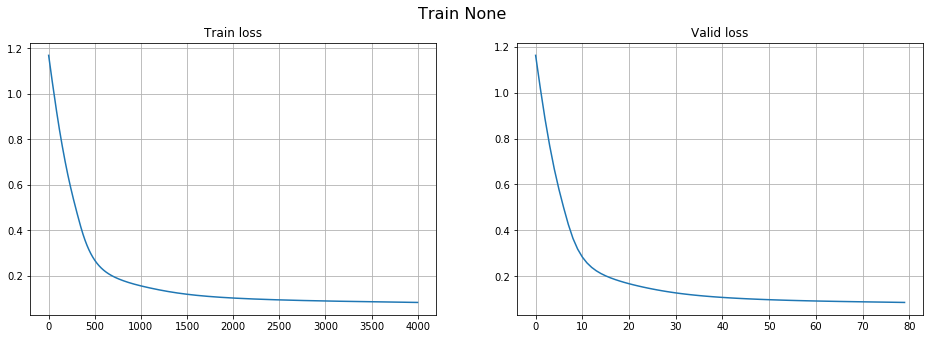

hidden_ts: 209.856
raw_ts: 286.496
Raw ts score: 0.927 +- 0.025
Hidden ts score: 0.929 +- 0.019


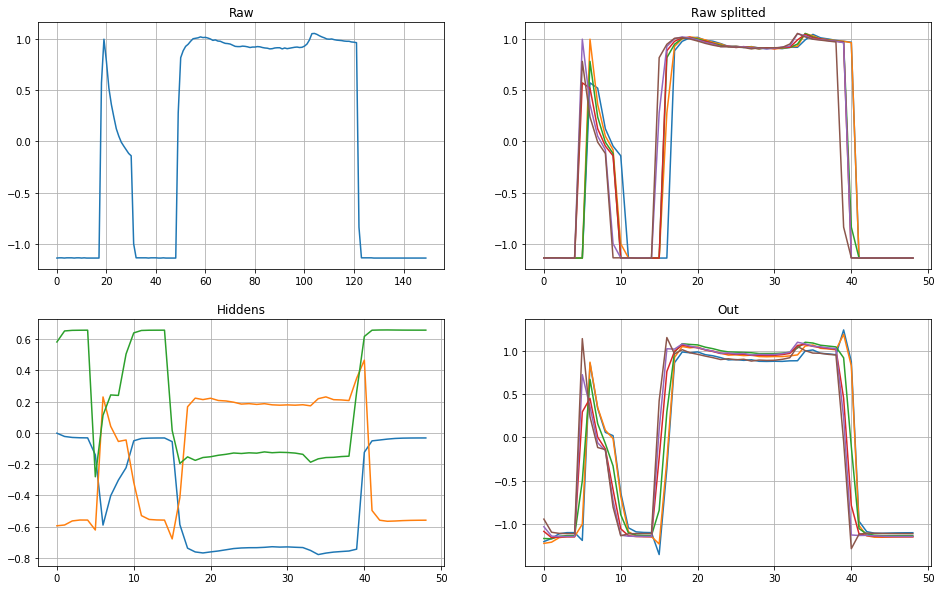

In [6]:
enc = Encoder(length, 2*k, hidden_dim).cuda()
dec = DecoderLinear(length, 2*k, hidden_dim).cuda()
model = Sequence2Sequence(enc, dec) 

opt = torch.optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
utils.train(model, train_set, opt, loss_fn, valid_set, 4000)

hiddens, state = enc(batch.permute(1, 0, 2))
x_out = dec(hiddens, state).permute(1, 0, 2).cpu().detach().numpy()
hiddens = hiddens.permute(1, 0, 2).cpu().detach().numpy()

_ = utils.classify(timeseries, hiddens, labels)
utils.plot(timeseries, batch.cpu(), hiddens, x_out, 20)

In [17]:
with open("results_ae_l.json", "w") as f:
    json.dump(results, f, cls=utils.NumpyEncoder)

# Experiments

* Select $sample\_size$ items of length $n$ from dataset .
* Split into train, test, valid.  
    P.S.: *Now valid set is unused.*
    
* Split each ts into sequence of small time-series  
    **Parameters**
    * $w$: shift size
    * $k$: 2*k - window size 
    * $h$: hidden dimension, dimension of each point after encoding
    
    The length of new sequence:
$$l = \dfrac{n-2k}{w} + 1 $$
    Encoder: 
$$
 \mathbf{R}^{l\times 2k} \rightarrow \mathbf{R}^{l\times h}
$$
    
* Train autoencoder or PCA on train test.
* Encode valid set
* Calculate distance matrix. (c engine is used only for univariate ts. So, we can't directly compare times)
* Classify hiddens and raw time series via KNN classifier.
    * Split valid dataset into classify_train, classify_test. Classify_test size = 0.7 * valid size.
    * KNN with k = 3 now.
    * Repeat many times
      

## AE
### Linear Decoder <-- now
### LSTM Decoder

* Valid size = $20\%$ of sample size.
* Train size = $75\%$ of sample size.

In [27]:
with open("results_ae_l.json") as f:
    results = json.load(f)

    
header = "{0:3s} | {1:^20s} | {2:^7s} | {3:^6s} | {4:^12s} | {5:^12s} ".format(
    "", "Problem", "N items", "Length", "Raw ts score", "Hidden score")
print(header)
print("-"*len(header))

for idx, problem in enumerate([name for name in datasets if lengths[name] < 200]):    
    length = lengths[problem]
    print("{:3d} | {:>20s} | {:7d} | {:6d} | {:.2f} +- {:.2f} | {:.2f} +- {:.2f} ".format(
        idx, problem[:20],
        results[problem]["shape"][0],
        results[problem]["shape"][1],
        np.mean(results[problem]["ts"]), np.std(results[problem]["ts"]),
        np.mean(results[problem]["hidden"]), np.std(results[problem]["hidden"]),    
    ))

    |       Problem        | N items | Length | Raw ts score | Hidden score 
----------------------------------------------------------------------------
  0 |                ACSF1 |     150 |     50 | 1.00 +- 0.00 | 1.00 +- 0.00 
  1 |                Adiac |     150 |    175 | 0.20 +- 0.04 | 0.19 +- 0.05 
  2 |   AllGestureWiimoteX |     150 |    115 | 0.62 +- 0.06 | 0.67 +- 0.05 
  3 |   AllGestureWiimoteY |     150 |    115 | 0.76 +- 0.04 | 0.78 +- 0.05 
  4 |   AllGestureWiimoteZ |     150 |    115 | 0.59 +- 0.06 | 0.59 +- 0.05 
  5 |            BeetleFly |     120 |    150 | 0.58 +- 0.05 | 0.58 +- 0.06 
  6 |                  BME |     150 |    128 | 0.91 +- 0.05 | 0.99 +- 0.04 
  7 |                  CBF |     150 |    128 | 0.99 +- 0.02 | 0.95 +- 0.04 
  8 |            Chinatown |     150 |     24 | 0.95 +- 0.03 | 0.93 +- 0.03 
  9 | ChlorineConcentratio |     150 |    150 | 0.38 +- 0.06 | 0.37 +- 0.05 
 10 |                 Crop |     150 |     46 | 1.00 +- 0.00 | 1.00 +- 0.00 